# Import Libraries

In [1]:
import torch, torchvision
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

In [2]:
from glob import glob
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
from sklearn.model_selection import train_test_split

import time
import copy
from tqdm.notebook import tqdm

import pandas as pd

# Process Data

In [3]:
labels = {
    0: 'Mitochondria',
    1: 'Nuclear bodies',
    2: 'Nucleoli',
    3: 'Golgi apparatus',
    4: 'Nucleoplasm',
    5: 'Nucleoli fibrillar center',
    6: 'Cytosol',
    7: 'Plasma membrane',
    8: 'Centrosome',
    9: 'Nuclear speckles'
}

In [4]:
def encode_label(label):
    target = torch.zeros(10)
    if label is not None and label != "":
        for l in str(label).split(' '):
            target[int(l)] = 1.
    return target

def decode_target(target, text_labels=False, threshold=0.5):
    result = []
    for i, x in enumerate(target):
        if (x >= threshold):
            if text_labels:
                result.append(labels[i] + "(" + str(i) + ")")
            else:
                result.append(str(i))
    return ' '.join(result)

In [5]:
class HumanProteinDataset(Dataset):
    def __init__(self, df, root_dir, transform=None):
        self.df = df
        self.transform = transform
        self.root_dir = root_dir
        
    def __len__(self):
        return len(self.df)    
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_id, img_label = row['Image'], row['Label']
        img_fname = self.root_dir + "/" + str(img_id) + ".png"
        img = Image.open(img_fname)
        if self.transform:
            img = self.transform(img)
        return img, encode_label(img_label)

In [6]:
train_df = pd.read_csv(os.path.join("D:", "data", "jovian_kaggle_protein", "Human protein atlas", "train.csv"))
train_df, valid_df = train_test_split(train_df, test_size=0.1, random_state=42)

In [7]:
# # train_transform = transforms.Compose([transforms.Resize((128, 128)), 
# #                                       transforms.RandomVerticalFlip(),
# #                                       transforms.RandomHorizontalFlip(),
# #                                       transforms.ToTensor()])

imagenet_stats = ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

# train_transform = transforms.Compose([
#     transforms.RandomCrop(256, padding=8, padding_mode='reflect'),
#     transforms.ColorJitter(brightness=0.05, contrast=0.05, saturation=0.05, hue=0.05),
#     transforms.RandomHorizontalFlip(), 
#     transforms.RandomRotation(10),
#     transforms.ToTensor(), 
#     transforms.Normalize(*imagenet_stats,inplace=True), 
# #     transforms.RandomErasing(inplace=True)
# ])

# val_transform = transforms.Compose([transforms.Resize((256, 256)), 
#                                     transforms.ToTensor(),     
#                                     transforms.Normalize(*imagenet_stats,inplace=True)])

# train_ds = HumanProteinDataset(train_df, 
#                                os.path.join("D:", "data", "jovian_kaggle_protein", "Human protein atlas", "train_256"), 
#                                transform=train_transform)
# valid_ds = HumanProteinDataset(valid_df, 
#                                os.path.join("D:", "data", "jovian_kaggle_protein", "Human protein atlas", "train_256"), 
#                                transform=val_transform)

# # train_ds = HumanProteinDataset(train_df, 
# #                                os.path.join("D:", "data", "jovian_kaggle_protein", "Human protein atlas", "train"), 
# #                                transform=train_transform)
# # valid_ds = HumanProteinDataset(valid_df, 
# #                                os.path.join("D:", "data", "jovian_kaggle_protein", "Human protein atlas", "train"), 
# #                                transform=val_transform)

In [8]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda', index=0)

In [150]:
class ProteinNet(LightningModule):
    def __init__(self, train_df):
        super().__init__()
        self.model = torch.hub.load('pytorch/vision:v0.6.0', 'resnet18', pretrained=True)
        self.model.fc = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Linear(64, 10)
        )
        self.train_df = train_df
        self.loss_fn = nn.BCEWithLogitsLoss()

       
    def forward(self, x):
        return self.model(x)
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-3)
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.loss_fn(logits, y)
        logs = {'loss': loss}
        return {'loss': loss, 'log': logs}
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.loss_fn(logits, y)
        f1_score = F_score(logits, y)
        logs = {'loss': loss}
        f1_score_log = {"f1_score": f1_score}
        return {'loss': loss, 'log': logs, "f1_score": f1_score}
    
    def freeze(self):
        for param in self.model.parameters():
            param.requires_grad = False
        for param in self.model.fc.parameters():
            param.requires_grad = True
            
    def unfreeze(self):
        for param in self.model.parameters():
            param.requires_grad = True

In [147]:
def train_dataloader(train_df):
    imagenet_stats = ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

    train_transform = transforms.Compose([
        transforms.RandomCrop(256, padding=8, padding_mode='reflect'),
        transforms.ColorJitter(brightness=0.05, contrast=0.05, saturation=0.05, hue=0.05),
        transforms.RandomHorizontalFlip(), 
        transforms.RandomRotation(10),
        transforms.ToTensor(), 
        transforms.Normalize(*imagenet_stats,inplace=True), 
    #     transforms.RandomErasing(inplace=True)
    ])
    train_ds = HumanProteinDataset(train_df, 
                                   os.path.join("D:", "data", "jovian_kaggle_protein", "Human protein atlas", "train_256"), 
                                   transform=train_transform)
    return DataLoader(train_ds, batch_size=64, shuffle=True, pin_memory=True)


def valid_dataloader(valid_df):
    imagenet_stats = ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

    val_transform = transforms.Compose([transforms.Resize((256, 256)), 
                                        transforms.ToTensor(),     
                                        transforms.Normalize(*imagenet_stats,inplace=True)])
    
    valid_ds = HumanProteinDataset(valid_df, 
                                   os.path.join("D:", "data", "jovian_kaggle_protein", "Human protein atlas", "train_256"), 
                                   transform=val_transform)
    return DataLoader(valid_ds, batch_size=64, shuffle=True, pin_memory=True)

In [148]:
train_dl = train_dataloader(train_df)
valid_dl = valid_dataloader(valid_df)

In [151]:
model = ProteinNet(train_df)
model.freeze()
trainer = Trainer(gpus=1, amp_level='O3', max_epochs=3)
trainer.fit(model, train_dl, valid_dl)

model.unfreeze()
trainer.max_epochs = 10
trainer.fit(model, train_dl, valid_dl)

Using cache found in C:\Users\krish/.cache\torch\hub\pytorch_vision_v0.6.0
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]
c:\miniconda3\envs\ml\lib\site-packages\pytorch_lightning\utilities\distributed.py:25: RuntimeWarning: You have defined a `val_dataloader()` and have defined a `validation_step()`, you may also want to define `validation_epoch_end()` for accumulating stats.
  warnings.warn(*args, **kwargs)

  | Name    | Type              | Params
----------------------------------------------
0 | model   | ResNet            | 11 M  
1 | loss_fn | BCEWithLogitsLoss | 0     
c:\miniconda3\envs\ml\lib\site-packages\pytorch_lightning\utilities\distributed.py:25: UserWarning: Your val_dataloader has shuffle=True, it is best practice to turn this off for validation and test dataloaders.
  warnings.warn(*args, **kwargs)


c:\miniconda3\envs\ml\lib\site-packages\pytorch_lightning\utilities\distributed.py:25: RuntimeWarning: The metric you returned None must be a `torch.Tensor` instance, checkpoint not saved HINT: what is the value of val_loss in validation_epoch_end()?
  warnings.warn(*args, **kwargs)
c:\miniconda3\envs\ml\lib\site-packages\pytorch_lightning\utilities\distributed.py:25: RuntimeWarning: Can save best model only with val_loss available, skipping.
  warnings.warn(*args, **kwargs)



  | Name    | Type              | Params
----------------------------------------------
0 | model   | ResNet            | 11 M  
1 | loss_fn | BCEWithLogitsLoss | 0     


1

In [9]:
def create_model():
    model = torch.hub.load('pytorch/vision:v0.6.0', 'resnet18', pretrained=True)
    for param in model.parameters():
        param.requires_grad = False
    model.fc = nn.Sequential(
        nn.Linear(512, 256),
        nn.ReLU(),
        nn.Linear(256, 64),
        nn.ReLU(),
        nn.Linear(64, 16),
        nn.ReLU(),
        nn.Linear(16, 10)
    )
    return model

In [10]:
def F_score(output, label, threshold=0.5, beta=1):
    prob = output > threshold
    label = label > threshold

    TP = (prob & label).sum(1).float()
    TN = ((~prob) & (~label)).sum(1).float()
    FP = (prob & (~label)).sum(1).float()
    FN = ((~prob) & label).sum(1).float()

    precision = torch.mean(TP / (TP + FP + 1e-12))
    recall = torch.mean(TP / (TP + FN + 1e-12))
    F2 = (1 + beta**2) * precision * recall / (beta**2 * precision + recall + 1e-12)
    return F2.mean(0)

In [11]:
def validate(model, valid_dl, device="cpu"):
    loss_fn = nn.BCEWithLogitsLoss()
    losses = []
    f1_metrics = []
    total = 0
    for images, labels in valid_dl:
        images = images.to(device)
        labels = labels.to(device)
        pred = model(images)
        loss = loss_fn(pred, labels)
        f1_metric = F_score(pred, labels, 0.5, 1)
        f1_metrics.append(f1_metric.item())
        total+=len(labels)
        losses.append(loss.item() * len(labels))
    return np.sum(losses)/total, np.mean(f1_metrics)

In [12]:
def train(model, train_dl, valid_dl, numb_epochs=5, learning_rate=1e-3, device="cpu"):
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    loss_fn = nn.BCEWithLogitsLoss()

    training_losses = []
    validation_losses = []
    validation_f1_scores = []

    max_f1_score = -1

    for epoch in range(numb_epochs):
        losses = []
        total = 0
        for images, labels in tqdm(train_dl):
            images = images.to(device)
            labels = labels.to(device)
            pred = model(images)
            optimizer.zero_grad()
            loss = loss_fn(pred, labels)

            loss.backward()
            optimizer.step()
            
            losses.append(loss.item() * len(labels))
            total+=len(labels)
        
        train_avg_loss = np.sum(losses)/total
        valid_avg_loss, f1_score_avg = validate(model, valid_dl, device=device)

        training_losses.append(train_avg_loss)
        validation_losses.append(valid_avg_loss)
        validation_f1_scores.append(f1_score_avg)

        if max_f1_score < f1_score_avg:
            max_f1_score = f1_score_avg
            best_model = copy.deepcopy(model)
            print("Better Model")

        print(f"Epoch: {epoch+1} Training Loss: {train_avg_loss} Validation Loss: {valid_avg_loss} Validation F1 Score: {f1_score_avg}")

    plt.plot(training_losses, label="Training Loss")
    plt.plot(validation_losses, label="Validation Loss")
    plt.plot(validation_f1_scores, label="Validation F1 Scores")
    plt.legend()
    plt.show()
    return best_model, max_f1_score
        

In [13]:
for param in best_model.parameters():
    param.requires_grad = True
#     print(param.requires_grad)
    pass

NameError: name 'best_model' is not defined

In [13]:
def resize_images(sz):
    for image_fname in tqdm(glob(os.path.join("D:", "data", "jovian_kaggle_protein", "Human protein atlas", "train", "*.png"))):
        img = Image.open(image_fname)
        fname = os.path.basename(image_fname)
        img = img.resize((sz, sz))
        img.save(os.path.join("D:", "data", "jovian_kaggle_protein", "Human protein atlas", "train_" + str(sz), fname))

In [14]:
hyperpar_df = pd.read_csv("hyperparameters.csv")
cols = hyperpar_df.columns
print(cols)

Index(['img_size', 'numb_epochs', 'learning_rate', 'norm', 'random_rotation',
       'color_jitter', 'random_crop', 'random_horiz_flip', 'random_erase'],
      dtype='object')


In [103]:
hyperparams = []
cols = hyperpar_df.columns
for i in range(len(cols)):
    hyperparams.append(hyperpar_df.iloc[[0]][cols[i]][0])

In [104]:
hyperparams

[256, 10, 0.001, False, False, False, False, False, False]

In [18]:
def transformations_func(hyperparams):
    train_transformations = []
    valid_transformations = []
    train_transformations.append(transforms.Resize((hyperparams[0], hyperparams[0])))
    valid_transformations.append(transforms.Resize((hyperparams[0], hyperparams[0])))
    if hyperparams[6] == True:
        train_transformations.append(transforms.RandomCrop(hyperparams[0], padding=8, padding_mode='reflect'))
    if hyperparams[5] == True:
        train_transformations.append(transforms.ColorJitter(brightness=0.05, contrast=0.05, saturation=0.05, hue=0.05))
    if hyperparams[7] == True:
        train_transformations.append(transforms.RandomHorizontalFlip())
    if hyperparams[4] == True:
        train_transformations.append(transforms.RandomRotation(10))
    valid_transformations.append(transforms.ToTensor())  
    train_transformations.append(transforms.ToTensor())
    if hyperparams[3] == True:
        train_transformations.append(transforms.Normalize(*imagenet_stats,inplace=True))
        valid_transformations.append(transforms.Normalize(*imagenet_stats,inplace=True))
    if hyperparams[8] == True:
        train_transformations.append(transforms.RandomErasing(inplace=True))
    return train_transformations, valid_transformations

In [19]:
train_transformations, valid_transformations = transformations_func(hyperparams)
print(train_transformations)
print(valid_transformations)

[Resize(size=(256, 256), interpolation=PIL.Image.BILINEAR), ToTensor()]
[Resize(size=(256, 256), interpolation=PIL.Image.BILINEAR), ToTensor()]


In [20]:
def return_ds(train_transformations, valid_transformations):
    train_transform = transforms.Compose(train_transformations)

    valid_transform = transforms.Compose(valid_transformations)

    train_ds = HumanProteinDataset(train_df, 
                                   os.path.join("D:", "data", "jovian_kaggle_protein", "Human protein atlas", "train_" + str(hyperparams[0])), 
                                   transform=train_transform)
    valid_ds = HumanProteinDataset(valid_df, 
                                   os.path.join("D:", "data", "jovian_kaggle_protein", "Human protein atlas", "train_" + str(hyperparams[0])), 
                                   transform=valid_transform)
    return train_ds, valid_ds

In [21]:
train_ds, valid_ds = return_ds(train_transformations, valid_transformations)

tensor([0., 0., 0., 0., 0., 0., 1., 0., 0., 1.])


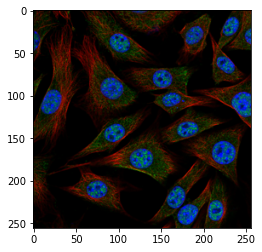

In [34]:
idx = 0
plt.imshow(train_ds[idx][0].permute(1, 2, 0))
print(train_ds[idx][1])

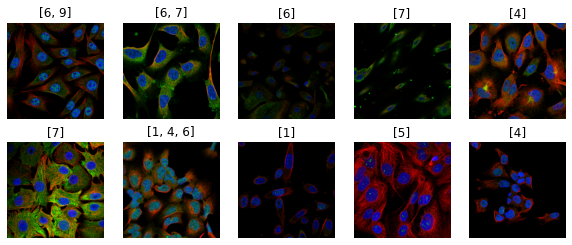

In [23]:
fig = plt.figure(figsize=(10, 4))
for i in range(1, 11):
    img = train_ds[i-1][0]
    fig.add_subplot(2, 5, i)
    plt.axis("off")
    label = torch.where(train_ds[i-1][1] == 1)[0]
    print_label = []
    for j in range(len(label)):
        print_label.append(label[j].item())
    plt.title(print_label, color = "black")
    plt.imshow(img.permute(1, 2, 0))
plt.show()

In [24]:
train_dl = DataLoader(train_ds, batch_size=64, shuffle=True, pin_memory=True)
valid_dl = DataLoader(valid_ds, batch_size=64, shuffle=True, pin_memory=True)

In [ ]:
model = create_model().to(device)
base_line_model, max_f1_score = train(model, train_dl, valid_dl, int((3/10) * hyperparams[1]), hyperparams[2], device=device)

In [117]:
def runner(hyperpar_df):
    cols = hyperpar_df.columns
    for idx in range(2, len(hyperpar_df)+1):
        hyperparams = []
        for i in range(len(cols)):
            hyperparams.append(hyperpar_df.iloc[[idx]][cols[i]].item())
        train_transformations, valid_transformations = transformations_func(hyperparams)
        train_ds, valid_ds = return_ds(train_transformations, valid_transformations)
        
        train_dl = DataLoader(train_ds, batch_size=64, shuffle=True, pin_memory=True)
        valid_dl = DataLoader(valid_ds, batch_size=64, shuffle=True, pin_memory=True)
        
        if idx == 1:
            for layer in base_line_model.parameters():
                layer.requires_grad = True 
            best_model, max_f1_score = train(base_line_model, train_dl, valid_dl, int((7/10) * hyperparams[1]), hyperparams[2], device=device)
        else:
            best_model = create_model()
            best_model.load_state_dict(torch.load(os.path.join("best_models", "best_model_" + str(idx-1) + ".pth")))
            best_model.train()
            for layer in best_model.parameters():
                layer.requires_grad = True 
            best_model, max_f1_score = train(best_model.to(device), train_dl, valid_dl, int((7/10) * hyperparams[1]), hyperparams[2], device=device)
                
        torch.cuda.empty_cache()
        torch.save(best_model.state_dict(), os.path.join("best_models", "best_model_" + str(idx) + ".pth"))
        with open("model_f1_accuracy.txt", "a") as f:
            f.write(str(idx) + ": " + str(max_f1_score) + '\n')
        
        print()
        print("Next set of hyperparameters")
        print()

In [125]:
with open("best_f1_score.txt", 'r') as f:
    line = f.readline().split(' ')
    if line[0] == -1:
        with open("best_f1_score.txt", 'w') as f:
            f.write(str(idx))

In [118]:
runner(hyperpar_df)

Using cache found in C:\Users\krish/.cache\torch\hub\pytorch_vision_v0.6.0


KeyboardInterrupt: 

In [110]:
torch.cuda.empty_cache()

# Save Model

In [20]:
torch.save(best_model.state_dict(), "best_model.pth")

# Load Model

In [17]:
best_model = create_model()
best_model.load_state_dict(torch.load("best_model.pth"))
best_model.eval()

Using cache found in C:\Users\krish/.cache\torch\hub\pytorch_vision_v0.6.0


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

# Submission

In [21]:
submission_df = pd.read_csv(os.path.join("D:", "data", "jovian_kaggle_protein", "submission.csv"))

In [22]:
test_ds = HumanProteinDataset(submission_df, os.path.join("D:", "data", "jovian_kaggle_protein", "Human protein atlas", "test"), transform=val_transform)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


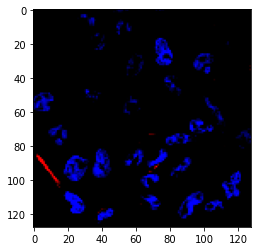

In [26]:
plt.imshow(test_ds[0][0].permute(1, 2, 0));

In [31]:
test_dl = DataLoader(test_ds, batch_size=64, shuffle=False, pin_memory=True)

In [33]:
def predict_image(model, image, device="cpu"):
    new_img = image.unsqueeze(0)
    new_img = new_img.to(device)
    with torch.no_grad():
        pred = model(new_img)
    pred = pred.data.cpu()
    prediction = torch.sigmoid(pred[0])
    print(prediction)
    plt.imshow(image.permute(1, 2, 0))
    print('Labels:', decode_target(prediction, text_labels=True, threshold=0.1))

In [22]:
predict_image(model, train_ds[0][0], device=device)

NameError: name 'model' is not defined

In [48]:
@torch.no_grad()
def predict_dl(dl, model, device="cpu"):
    batch_probs = []
    model.eval()
    for xb, _ in tqdm(dl):
#         torch.cuda.empty_cache()
        xb = xb.to(device)
        probs = model(xb)
        batch_probs.append(probs.cpu().detach())
    batch_probs = torch.cat(batch_probs)
    return [decode_target(x, threshold=0.1) for x in batch_probs]

In [49]:
test_preds = predict_dl(test_dl, best_model.to(device), device=device)

In [50]:
submission_df.Label = test_preds
submission_df.head()

,Image,Label
0,24117,3 4 8
1,15322,4
2,14546,6
3,8079,6
4,13192,3 4


In [51]:
submission_df.to_csv("resnet_18_submission.csv", index=False)